In [1]:
import numpy as np

import matplotlib.pyplot as plt

# Poisson Equation

Consider the Poisson equation:

$$ \nabla^{2} \phi = f $$

This is a second-order elliptic equation and therefore requires two boundary conditions.

There is no time-dependence in this equation. The potential $\phi$ responds instantaneously to the source $f$ and the boundary conditions.

Consider the one-dimensional Poisson Equation:

$$ \phi'' = f $$

on the domain $[a, b]$

We can supply boundary conditions as

* Dirichlet: $\phi(a) = A $
* Neumann: $\phi'(a) = C $

or a mix of the two. If the values are set to 0, we call the conditions homogeneous, otherwise they are called inhomogeneous.

Not any set of boundary conditions is allowed. Consider $f=0$ so our Poisson equation is the Laplace equationo:

$$\phi'' = 0 $$

and the solution is just $\phi(x) = ax + b $

If we try to enforce different inhomogeneous Neumann boundary conditions on each end, then we get conflicting values for the slope and hence this will be unsolvable.

To understand solvable boundary conditions for the general case, we start by integrating over the domain.

$$ \int_{\Omega} \nabla^2 \phi \phantom{a} d\Omega = \int_{\delta \Omega} \nabla \phi \cdot \bf{n} \phantom{a} d \mathcal{S} = \int_{\Omega} \mathcal{f} \phantom{a} d \Omega $$

If we have homogeneous Neumann BCs on all sides, $\nabla \phi \cdot \bf{n} = 0 $, then the source $\mathcal{f}$, must satisfy

$$\int_{\Omega} \mathcal{f} \phantom{a} d \Omega = 0 $$

The same condition will apply if the boundary conditions are periodic

# Relaxation

A second order accurate discretization of the second derivative is:

$$ \phi''_{i} = \frac{\phi_{i+1} - 2 \phi_{i} + \phi_{i-1}}{\Delta x^2} $$

This is true on finite-difference and finite-volume grids (to second order in $\Delta x$)

We will work in 1-d so our Poisson Equation

$$ \phi'' = f$$

becomes:

$$ \frac{\phi_{i+1} - 2 \phi_{i} - \phi_{i-1}}{\Delta x^2} = f_{i} $$

Using this discretization for all zones $i$ in $0, .., N-1$ results in $N$ coupled algebraic equations.

We can solve for the update for a single zone:

$$\phi_{i} = \frac{1}{2} (\phi_{i+1} - 2 \phi_{i-1} - \Delta x^2 f_{i}) $$

We can solve this by writing it as a linear system, $ Ax = b$, with $A$ as a triangular matrix with diagonals $1$, $-2$, $1$ and $b$ corresponding to $f_{i}$. This approach is a "direct solve" of the coupled equations. But this can be expensive in multi-dimensions and harder to parallelize if domain decomposition is used.

Instead of directly solving the linear system, we can use relaxation which is an iterative approach that converges to the solution. Generally relaxation requires that the matrix be diagonally dominant, which we are just shy of, but nevertheless, relaxation works quite well for this system. There are two popular approaches we can consider:

* Jacobi iteration:
  * pick an initial guess $\phi^{(0)}_{i}$ for all $i$
  * Improve the guess via relaxation:
  $$ \phi^{(k+1)}_{i} = \frac{1}{2}(\phi^{(k)}_{i+1} + \phi^{(k)}_{i-1} - \Delta x^2 f_{i}) $$
  * Assess the error and if needed iterate

* Guess-Seidel (G-S) iteration:
  * pick an initial guess $\phi^{(0)}_{i}$ for all $i$
  * use the new data as it becomes available:
  $$\phi_{i} \longleftarrow \frac{1}{2}(\phi_{i+1} + \phi_{i-1} - \Delta x^2 f_{i}) $$
  * Note that there are no interation subscripts indicated here, since we are not keeping the old and new $\phi$ separate in memory. We keep only a single $\phi$ and update it as we sweep from $i = 0, ...., N-1$

A variation on the G-S Iteration is red-black Gauss-Seidel (think of a checkboard)
  * First update the odd points - they only depend on the even points
  * Next update the even points as they only depend on the odd points

Advantage of this red-black G-S iteration is that it makes it much easier to parallelize via domain decomposition. We will use this approach going forward

## Boundary Conditions

We need to pay special attention to the boundaries. This depends on what type of grid we are using.

For a finite-difference (node centered) grid:

![finite difference grid](https://drive.google.com/uc?id=1Fk1hbOSfxzJzf2PJUhD5YJLQ668JeJ-L)

we have a point exactly on each boundary, so we only need to iterate over the interior points.

In contrast, for a finite-volume or cell-centered finite-difference grid:

![ccfd_grid_bnd](https://drive.google.com/uc?id=1-2G4WuFwFtqaya5JjSH5et5Gvff7J0pW)


we don't have data on the physical boundaries so we will need to interpolate to the boundary.

We will work with the cell-centered grid, witha single ghost point which is how we will set the boundary conditions. We will label the first interior zone as $lo$ and the last interior cell as $hi$. Imagine that the domain runs from $[a, b]$.

![ccfd_ghost](https://drive.google.com/uc?id=1-3GOd4zIHEGUF136HbkBOYN4crji-M4R)

Consider the following boundary conditions:

  * Dirichlet: we need the value on the boundary itself to satisfy the boundary condition:
$$\phi(a) = A$$

  A naive guess would be to set $\phi_{lo-1} = A$ but this is only first order accurate

  Instead we recognize that we can average across the boundary to be second order on the boundary:

  $$ A = \frac{\phi_{lo} + \phi_{lo-1}}{2} $$

  which gives the ghost cell value:

  $$\phi_{lo-1} = 2A - \phi_{lo} $$

  * Neumann: we need a gradiant, centered at the boundary to match the given value:
  $$\phi'(a) = C $$

  A second order accurate discretization on the boundary is:

  $$C = \frac{\phi_{lo} - \phi_{lo-1}}{\Delta x} $$

  so we would initialize the ghost cell as:

  $$\phi_{lo} = \phi_{lo} - \Delta x C $$

## First Implementation - Red-Black Gauss-Seidel Iteration

Let is start by writing a grid class that holds the solution and the RHS and knows how to full the ghost cell

In [2]:
class Grid:
    def __init__(self, nx, ng=1, xmin=0, xmax=1,bc_left_type="dirichlet", bc_left_val=0.0, bc_right_type="neumann", bc_right_val=0.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx
        
        self.bc_left_type = bc_left_type
        self.bc_left_val = bc_left_val
        
        self.bc_right_type = bc_right_type
        self.bc_right_val = bc_right_val
        
        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.phi = self.scratch_array()
        self.f = self.scratch_array()
        
    def scratch_array(self):
        """return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    # norm definitions added during the residuals section
    def norm(self, e):
      """compute the L2 norm of e that lives on our grid"""
      return np.sqrt(self.dx * np.sum(e[self.ilo:self.ihi+1]**2))

    def residual_norm(self):
      """compute the residula norm"""
      r = self.scratch_array()
      r[self.ilo:self.ihi+1] = self.f[self.ilo:self.ihi+1] - (self.phi[self.ilo+1:self.ihi+2] - 2 * self.phi[self.ilo:self.ihi+1] + self.phi[self.ilo-1:self.ihi]) / self.dx**2
      return self.norm(r)

    def source_norm(self):
      """compute the source norm"""
      return self.norm(self.f)
    # norm distribution finished here

    def fill_bcs(self):
        """fill the boundary conditions on phi"""
        
        # we only deal with a single ghost cell here
        
        # left
        if self.bc_left_type.lower() == "dirichlet":
            self.phi[self.ilo-1] = 2 * self.bc_left_val - self.phi[self.ilo]
        elif self.bc_left_type.lower() == "neumann":
            self.phi[self.ilo-1] = self.phi[self.ilo] - self.dx * self.bc_left_val
        else:
            raise ValueError("invalid bc_left_type")
            
        # right
        if self.bc_right_type.lower() == "dirichlet":
            self.phi[self.ihi+1] = 2 * self.bc_right_val - self.phi[self.ihi]
        elif self.bc_right_type.lower() == "neumann":
            self.phi[self.ihi+1] = self.phi[self.ihi] - self.dx * self.bc_right_val
        else:
            raise ValueError("invalid bc_right_type")

Next we will write a smooth routine that does a single pass of the red-black G-S

In [3]:
def smooth(g):
    """perform red-black Gauss-Seidel smoothing"""
    
    g.fill_bcs()
    
    g.phi[g.ilo:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.f[g.ilo:g.ihi+1:2] + g.phi[g.ilo+1:g.ihi+2:2] + g.phi[g.ilo-1:g.ihi:2])
    
    g.fill_bcs()

    g.phi[g.ilo+1:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.f[g.ilo+1:g.ihi+1:2] + g.phi[g.ilo+2:g.ihi+2:2] + g.phi[g.ilo:g.ihi:2])

Now we are ready to try this out. Let's do the following problem:

$$ \phi'' = \sin(x) $$

on $[0, 1]$ with homogeneous Dirichlet BCs.

The solution is:

$$ \phi(x) = -\sin(x) + x \sin(1) $$

Let's create functions that initialize the RHS and the analytic solution so we can also ananlyze some error.

In [4]:
def analytic(x):
  return -np.sin(x) + x * np.sin(1.0)

def f(x):
  return np.sin(x)

Now we create the grid. We will use 128 points to start. The defaults for the grid class already set homogeneous Dirichlet BCs

In [5]:
g = Grid(128)

Now we need to initialize $\phi$ and $f$. For $\phi$, we might as well just initialize it to $0$ (which is already done for us in the grid class), since usually we do not know the answer.

In [6]:
g.f[:] = f(g.x)

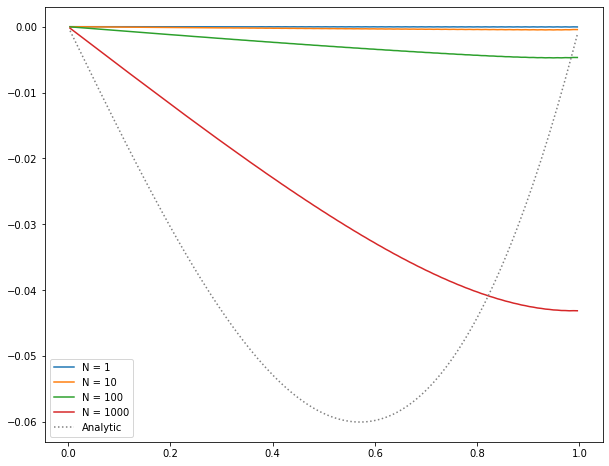

In [7]:
fig = plt.figure()
fig.set_size_inches(10, 8)
ax = fig.add_subplot(111)

niters = [1, 10, 100, 1000]

for n in niters:

  # smooth n times
  for _ in range(n):
    smooth(g)

  ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1], label=f"N = {n}")

  # reset phi to 0 for the next number of iterations
  g.phi[:] = 0.0

ax.plot(g.x[g.ilo:g.ihi+1], analytic(g.x[g.ilo:g.ihi+1]), ls=":", color="0.5", label="Analytic")

ax.legend()

We see that as we increase the number of smoothing iterations, we get closer to the analytic solution. Also note that the solution appears to be respecting our boundary conditions as well.

However, even after 1000 smoothing iterations we are still far from the true solution.

## Jacobi Iteration (To Do)

[Jacobi Iteration Site 1](https://www.quatstart.com/articles/Jacobi-Method-in-Python-and-NumPy/)

[Jacobi Iteration Site 2](https://newbedev.com/python-jacobi-iteration-python-code-example)

[Different Iterative Processes](https://github.com/TheAlgorithms/Python/tree/master/arithmetic_analysis)

[Another Jacobi Iterative Example](https://grabthiscode.com/python/jacobi-method-in-python)

[Last Jacobi Iterative Example - Looks Promising](https://gist.github.com/kreichgauer/4137321)

Should look at all and try to make a Jacobi iterative process to work with this example



# Residuals


We need a way to tell when to stop smoothing.

If we know the analytic solution, then we can just compare to that and keep iterating until the error is small, but that kinda defeats the purpose. Instead, we can measure how well we satisfy the discrete equation which is called the residual.

$$r_{i} = f_i - \frac{\phi^{(k)}_{i+1} - 2 \phi^{(k)}_{i} + \phi^{(k)}_{i-1}}{\Delta x^2} $$

We still need something to compare to, se we define the source norm $||f||$, and we will pick a tolerance $\epsilon$ and interate until:

$$ ||r|| < \epsilon ||f|| $$

For the special case of a homogeneous source ($f=0$) then we iterate until

$$ ||r|| < \epsilon $$

We will use the L2 norm:

$$ ||e||_{2} \equiv \left( \Delta x \sum_{i} |e_{i}|^2 \right)^{1/2} $$

Let's update our grid class to include a norm and residual. There is a section of norm definitions added to the Grid class at the top of this sheet.

Now we will write a relaxation function that does smoothing until either a maximum number of iterations is taken or we reach a desired tolerance. If the tolerance is set to None, then the routine will take the full amount of iterations.

In [8]:
class TooManyIterations(Exception):
  pass

def relax(g, tol=1.e-8, max_iters=200000, analytic=None):
  iter = 0
  fnorm = g.source_norm()
  if fnorm == 0.0:
    fnorm = tol

  r = g.residual_norm()

  res_norm = []
  true_norm = []

  if tol is None:
    test = iter < max_iters
  else:
    test = iter < max_iters and r > tol * fnorm

  g.fill_bcs()

  while test:
    g.phi[g.ilo:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.f[g.ilo:g.ihi+1:2] + g.phi[g.ilo+1:g.ihi+2:2] + g.phi[g.ilo-1:g.ihi:2])

    g.fill_bcs()

    g.phi[g.ilo+1:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.f[g.ilo+1:g.ihi+1:2] + g.phi[g.ilo+2:g.ihi+2:2] + g.phi[g.ilo:g.ihi:2])

    g.fill_bcs()

    r = g.residual_norm()
    res_norm.append(r)

    if analytic is not None:
      true_norm.append(g.norm(g.phi - analytic(g.x)))

    iter += 1

    if tol is None:
      test = iter <= max_iters
    else:
      test = iter < max_iters and r > tol * fnorm

  if tol is not None and iter >= max_iters:
    raise TooManyIterations(f"Too many iterations, niter = {iter}")

  return res_norm, true_norm

## Residuals vs. Truncation Error

Now we will look at how the residual error compares to the truncation error of our discretization. We will take a fixed number of iterations for our same model problem

$$ \phi'' = \sin(x) $$

on $[0, 1]$ with homogeneous BCs.

nx=16, true error = 0.17391393571488348
nx=32, true error = 0.17388834963244698
nx=64, true error = 0.17388047476477503
nx=128, true error = 0.1633344905417827
nx=256, true error = 0.07585935586506595
nx=512, true error = 0.020726252315852806


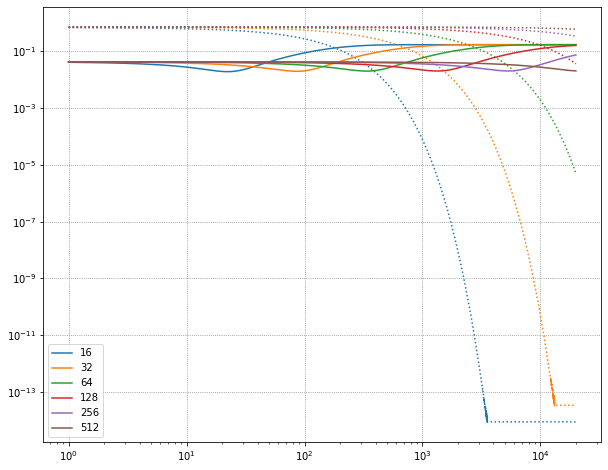

In [9]:
fig = plt.figure()
fig.set_size_inches(10,8)

ax = fig.add_subplot(111)

for i, nx in enumerate([16, 32, 64, 128, 256, 512]):
  g = Grid(nx)
  g.f[:] = f(g.x)

  res_norm, true_norm = relax(g, tol=None, max_iters=20000, analytic=analytic)
  n = np.arange(len(res_norm)) + 1

  ax.loglog(n, true_norm, label=f"{nx}", color=f"C{i}")
  ax.loglog(n, res_norm, ls=":", color=f"C{i}")

  print(f"nx={nx}, true error = {true_norm[-1]}")

ax.legend()
ax.grid(ls=":", color="0.5")

Let's take a look at what this shows us:

* The truncation error (solid line) stalls at a much higher value than the residual (dotted)
* The truncation error converges second order with the number of zones (look at the numbers printed during the run)
* As we increase the number of zones, we need more iterations until the residual drops to machine roundoff
* The residual error eventually reaches roundoff which indicates that we satisfy the discrete equation "exactly"

# Exercise (Code works but numerical solution is bad) Tried Dirichlet and Neumann - No difference 

Solve

$$\phi'' = -4 \pi^2 \cos(2 \pi x) $$

on $[0, 1]$ with homogeneous Neumann BCs

In [10]:
class grid:
    def __init__(self, nx, ng=10, xmin=0, xmax=1,
                 bc_left_type="dirichlet", bc_left_val=0.0,
                 bc_right_type="dirichlet", bc_right_val=0.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx
        
        self.bc_left_type = bc_left_type
        self.bc_left_val = bc_left_val
        
        self.bc_right_type = bc_right_type
        self.bc_right_val = bc_right_val
        
        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.phi = self.scratch_array()
        self.F = self.scratch_array()
        
    def scratch_array(self):
        """return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    # norm definitions added during the residuals section
    def norm(self, e):
      """compute the L2 norm of e that lives on our grid"""
      return np.sqrt(self.dx * np.sum(e[self.ilo:self.ihi+1]**2))

    def residual_norm(self):
      """compute the residula norm"""
      r = self.scratch_array()
      r[self.ilo:self.ihi+1] = self.F[self.ilo:self.ihi+1] - (self.phi[self.ilo+1:self.ihi+2] - 2 * self.phi[self.ilo:self.ihi+1] + self.phi[self.ilo-1:self.ihi]) / self.dx**2
      return self.norm(r)

    def source_norm(self):
      """compute the source norm"""
      return self.norm(self.F)
    # norm distribution finished here

    def Fill_bcs(self):
        """fill the boundary conditions on phi"""
        
        # we only deal with a single ghost cell here
        
        # left
        if self.bc_left_type.lower() == "dirichlet":
            self.phi[self.ilo-1] = 2 * self.bc_left_val - self.phi[self.ilo]
        elif self.bc_left_type.lower() == "neumann":
            self.phi[self.ilo-1] = self.phi[self.ilo] - self.dx * self.bc_left_val
        else:
            raise ValueError("invalid bc_left_type")
            
        # right
        if self.bc_right_type.lower() == "dirichlet":
            self.phi[self.ihi+1] = 2 * self.bc_right_val - self.phi[self.ihi]
        elif self.bc_right_type.lower() == "neumann":
            self.phi[self.ihi+1] = self.phi[self.ihi] - self.dx * self.bc_right_val
        else:
            raise ValueError("invalid bc_right_type")
        

In [11]:
def Analytic(x):
    return -4 * np.pi**2 * np.cos(2 * np.pi * x)

def F(x):
    return -4 * np.pi**2 * np.cos(2 * np.pi * x)

In [12]:
g = grid(128)

In [13]:
g.F[:] = F(g.x)

In [14]:
def Smooth(g):
    """perform red-black Gauss-Seidel smoothing"""
    
    g.Fill_bcs()
    
    g.phi[g.ilo:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.F[g.ilo:g.ihi+1:2] + g.phi[g.ilo+1:g.ihi+2:2] + g.phi[g.ilo-1:g.ihi:2])
    
    g.Fill_bcs()

    g.phi[g.ilo+1:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.F[g.ilo+1:g.ihi+1:2] + g.phi[g.ilo+2:g.ihi+2:2] + g.phi[g.ilo:g.ihi:2])

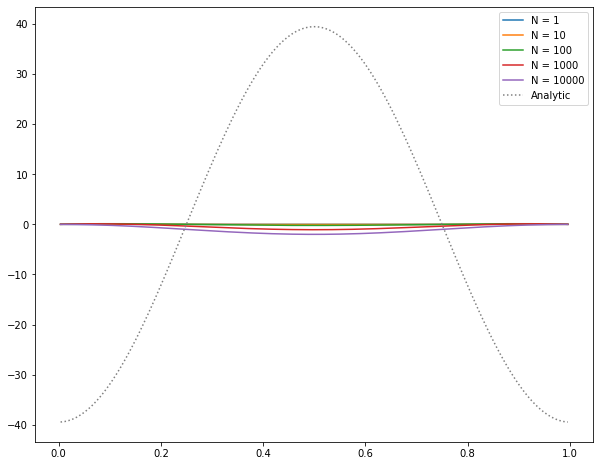

In [15]:
fig = plt.figure()
fig.set_size_inches(10, 8)
ax = fig.add_subplot(111)

niters = [1, 10, 100, 1000, 10000]

for n in niters:

  # smooth n times
  for _ in range(n):
    Smooth(g)

  ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1], label=f"N = {n}")

  # reset phi to 0 for the next number of iterations
  g.phi[:] = 0.0

ax.plot(g.x[g.ilo:g.ihi+1], Analytic(g.x[g.ilo:g.ihi+1]), ls=":", color="0.5", label="Analytic")

ax.legend()

In [16]:
class TooManyIterations(Exception):
  pass

def Relax(g, tol=1.e-8, max_iters=200000, analytic=None):
  iter = 0
  fnorm = g.source_norm()
  if fnorm == 0.0:
    fnorm = tol

  r = g.residual_norm()

  res_norm = []
  true_norm = []

  if tol is None:
    test = iter < max_iters
  else:
    test = iter < max_iters and r > tol * fnorm

  g.Fill_bcs()

  while test:
    g.phi[g.ilo:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.F[g.ilo:g.ihi+1:2] + g.phi[g.ilo+1:g.ihi+2:2] + g.phi[g.ilo-1:g.ihi:2])

    g.Fill_bcs()

    g.phi[g.ilo+1:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.F[g.ilo+1:g.ihi+1:2] + g.phi[g.ilo+2:g.ihi+2:2] + g.phi[g.ilo:g.ihi:2])

    g.Fill_bcs()

    r = g.residual_norm()
    res_norm.append(r)

    if analytic is not None:
      true_norm.append(g.norm(g.phi - Analytic(g.x)))

    iter += 1

    if tol is None:
      test = iter <= max_iters
    else:
      test = iter < max_iters and r > tol * fnorm

  if tol is not None and iter >= max_iters:
    raise TooManyIterations(f"Too many iterations, niter = {iter}")

  return res_norm, true_norm

nx=16, true error = 28.64895237617785
nx=32, true error = 28.642245523419906
nx=64, true error = 28.64058082591131
nx=128, true error = 28.64016220031213
nx=256, true error = 28.61321089123001
nx=512, true error = 28.386733365088165


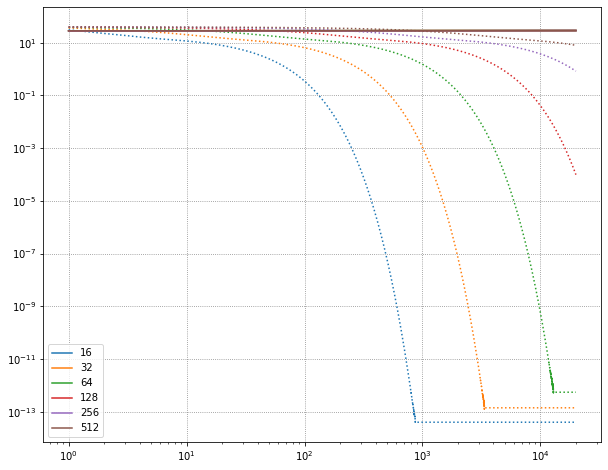

In [17]:
fig = plt.figure()
fig.set_size_inches(10,8)

ax = fig.add_subplot(111)

for i, nx in enumerate([16, 32, 64, 128, 256, 512]):
  g = grid(nx)
  g.F[:] = F(g.x)

  res_norm, true_norm = Relax(g, tol=None, max_iters=20000, analytic=Analytic)
  n = np.arange(len(res_norm)) + 1

  ax.loglog(n, true_norm, label=f"{nx}", color=f"C{i}")
  ax.loglog(n, res_norm, ls=":", color=f"C{i}")

  print(f"nx={nx}, true error = {true_norm[-1]}")

ax.legend()
ax.grid(ls=":", color="0.5")